(0.0, 40.0)

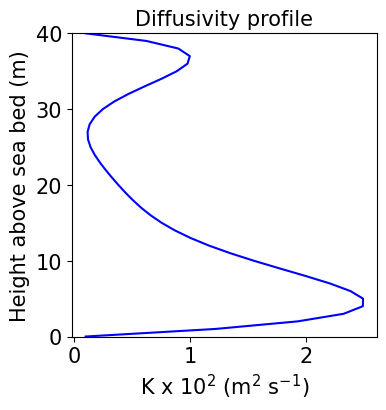

In [6]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from pylag.particle_cpp_wrapper import ParticleSmartPtr
from pylag.mock import MockVerticalDiffusivityDataReader
import pylag.random as random

from pylag.processing.plot import create_figure

# Ensure inline plotting
%matplotlib inline

# Seed the PRNG
random.seed()

# Create data reader
data_reader = MockVerticalDiffusivityDataReader()

# Get z min and max. We give dummy values for the time and
# particle arguments, which in this example, aren't used to
# compute z_min or z_max.
z_min = data_reader.get_zmin_wrapper(0.0, ParticleSmartPtr())
z_max = data_reader.get_zmax_wrapper(0.0, ParticleSmartPtr())
n_z_levels = 41

# Reference heights above the sea bed
z_levels = np.linspace(z_min, z_max, n_z_levels, dtype=float)

# Generate the profile for plotting
Kz = np.empty_like(z_levels)
for i, z in enumerate(z_levels):
    Kz[i] = data_reader.get_vertical_eddy_diffusivity_analytic(z)

# Create figure for plotting
font_size = 15
fig, ax = create_figure(figure_size=(10., 10.), font_size=font_size)

# Plot the diffusivity profile
ax.plot(Kz*100., z_levels, 'b')
ax.set_title('Diffusivity profile', fontsize=font_size)
ax.set_xlabel(r'K x 10$^{2}$ (m$^{2}$ s$^{-1}$)', fontsize=font_size)
ax.set_ylabel('Height above sea bed (m)', fontsize=font_size)
ax.set_ylim(ymin=z_min, ymax=z_max)

In [8]:
from configparser import ConfigParser

from pylag.mock import MockOneDNumMethod


def run_particle_simulation(model_name):
    """Run a single simulation

    An initial particle seed is created. Particle starting depths are uniformly
    distributed over the vertical grid. Particle trajectories and final positions
    are then computed by integrating the model forward in time using the named
    iterative method.

    Parameters:
    -----------
    model_name: str
        Name of the iterative method under test

    Returns:
    --------
    particle_depths: ndarray[# particles, time]
       2D numpy array of particle depths
    """
    # Create a run config
    config = ConfigParser()

    # Specify that we are not restoring to a fixed depth
    config.add_section("SIMULATION")
    config.set("SIMULATION", "depth_restoring", "False")
    config.set("SIMULATION", "fixed_depth", "0.0")

    # Set the coordinate system, which here is a simple cartesian coordinate system
    config.add_section('OCEAN_CIRCULATION_MODEL')
    config.set('OCEAN_CIRCULATION_MODEL', 'coordinate_system', 'cartesian')

    # Specify the numerical scheme we will use
    config.add_section("NUMERICS")
    config.set("NUMERICS", "num_method", "standard")
    config.set("NUMERICS", "iterative_method", model_name)
    config.set("NUMERICS", "time_step_diff", str(time_step))

    # Use a reflecting vertical boundary condition
    config.add_section("BOUNDARY_CONDITIONS")
    config.set("BOUNDARY_CONDITIONS", "vert_bound_cond", "reflecting")

    # Create test object using the run config
    num_method = MockOneDNumMethod(config)

    # Initial z positions - uniformly distributed in the first instance
    z_positions = []
    for i in range(n_particles):
        z_positions.append(random.uniform(z_min, z_max))

    # Create array in which to store particle depths
    particle_depths = np.empty((n_times, n_particles), dtype=float)

    # Integrate the model forward in time
    for t_idx, t in enumerate(time):
        # Save z positions for the last time point
        particle_depths[t_idx, :] = z_positions[:]

        # Compute new z positions
        z_positions[:] = num_method.step(data_reader, t, z_positions)[:]

    return particle_depths

# Running the particle tracking model 

To speed things up a bit, we use an object of type MockOneDNumMethod to help manage the integration. 
While not strictly necessary, it cythonizes the particle loop, which yields a speed up over doing the same operation in python.
Note the function references a time array, which we are yet to create. 
We set these below, then run ensemble simulations using different numerical approximation techniques. 
The data from each method are saved into separate arrays.

In [10]:
# time variables 

time_start = 0.0
time_end = 3600.0 *4 
time_step = 6.0
time = np.arange(time_start, time_end, time_step)
n_times = time.shape[0]
# No. of particles to use in each simulation
n_particles = 1000

#No. of trials to use in each ensemble
n_trials = 5

#stor outputs in a dictionary

particle_data = {'Diff_Naive_1D': np.empty((n_trials, n_times, n_particles), dtype=float),
                 'Diff_Euler_1D': np.empty((n_trials, n_times, n_particles), dtype=float),
                 'Diff_Visser_1D': np.empty((n_trials, n_times, n_particles), dtype=float),
                 'Diff_Milstein_1D': np.empty((n_trials, n_times, n_particles), dtype=float)
                }
#run the particle ensembles

for method, data in particle_data.items():
    for i in range(n_trials):
        data[i, :, :] = run_particle_simulation(method)[:,:]

# Visualising the result

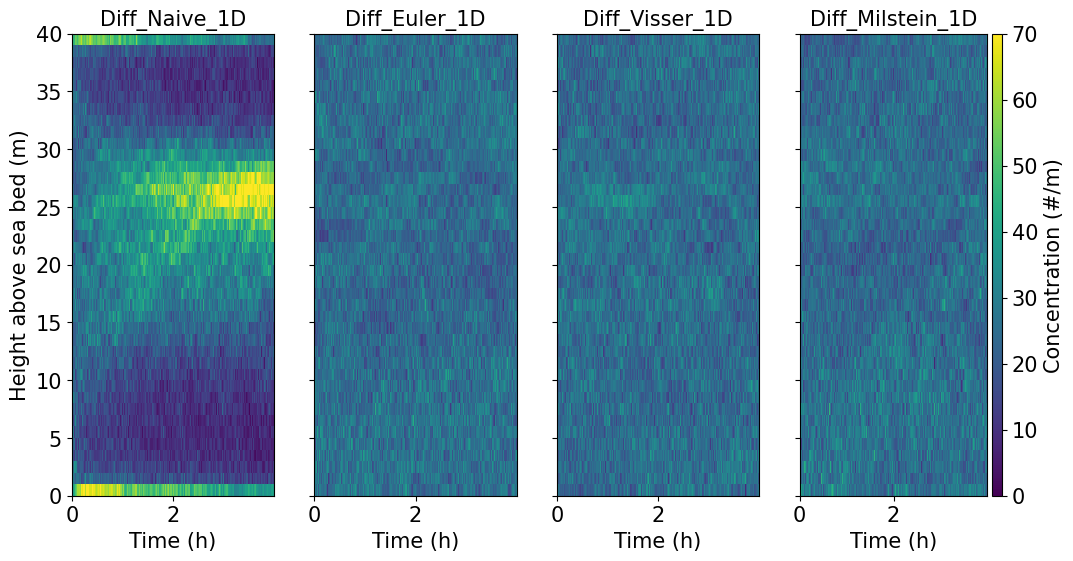

In [12]:
from pylag.processing.plot import create_cbar_ax

# Grids for plotting using pcolormesh
bin_edges = range(int(z_max-z_min) + 1)
time_out = np.arange(time_start-time_step/2., time_end + time_step/2., time_step)/3600.0
depth_out = np.array(bin_edges)
time_grid, depth_grid = np.meshgrid(time_out, depth_out)

# Create figure
fig, axarr = plt.subplots(nrows=1,ncols=4, figsize=(12, 6), sharey=True)

# Store plots and calculated concentrations in lists
concentrations = []
plots = []

# Loop over each method and plot the concentration of particles
for i, (name, data) in enumerate(particle_data.items()):
    concentration = np.empty((len(bin_edges)-1, n_times))
    for j in range(n_times):
        hist, bins = np.histogram(data[0,j,:], bins=bin_edges)
        concentration[:,j] = hist
    concentrations.append(concentration)

    plot = axarr[i].pcolormesh(time_grid, depth_grid, concentration, vmin=0, vmax=70)
    plots.append(plot)

    axarr[i].set_title('{}'.format(name), fontsize=font_size)
    axarr[i].set_xlabel('Time (h)', fontsize=font_size)
    axarr[i].tick_params(axis='both', which='major', labelsize=font_size)
    axarr[i].tick_params(axis='both', which='minor', labelsize=font_size)

axarr[0].set_ylabel('Height above sea bed (m)', fontsize=font_size)

# Add colour bar to the last plot
cax = create_cbar_ax(axarr[3])
cbar = fig.colorbar(plots[3], cax=cax)
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Concentration (#/m)', fontsize=font_size)


In [18]:
from pyqt_fit import kde, kde_methods, kernels

# Dictionary in which to store mean concentrations as a function of depth
means = {}

# Dictionary in which to store std's as a function of depth
stds = {}

# Compute KDE, means and std's for ...
#   - All methods
#   - All trials
#   - All time points
for i, (name, data) in enumerate(particle_data.items()):
    particle_kde = np.empty((n_trials, n_times, n_z_levels), dtype=float)
    for i in range(n_trials):
        for j in range(n_times):
            est = kde.KDE1D(data[i, j, :], lower=z_min, upper=z_max,
                    method=kde_methods.reflection, kernel=kernels.Epanechnikov())
            particle_kde[i, j, :] = n_particles * est(z_levels)

    means[name] = np.mean(particle_kde, axis=(0,1))
    stds[name] = np.std(particle_kde, axis=(0,1))

# Compute reference particle concentration (#/m)
ref_conc = n_particles/float(n_z_levels - 1)

# Create figure
fig, axarr = plt.subplots(nrows=1,ncols=4, figsize=(12, 6), sharey=True)

# Plot means and stds
for idx, name in enumerate(particle_data.keys()):
    axarr[idx].errorbar(means[name], z_levels, xerr=stds[name], fmt='-o', c='r')
    axarr[idx].axvline(ref_conc, ymin=0, ymax=1, c='k', linestyle='--')
    axarr[idx].set_title(name, fontsize=font_size)
    axarr[idx].set_xlabel('Particle conc (#/m)', fontsize=font_size)
    if name == 'Diff_Naive_1D':
        # Naive is known to fail so we set broarder xlims
        axarr[idx].set_xlim(xmin=0., xmax=2.*ref_conc)
    else:
        axarr[idx].set_xlim(xmin=ref_conc - ref_conc/4., xmax=ref_conc + ref_conc/4.)
    axarr[idx].set_ylim(ymin=z_min, ymax=z_max)

# Tidy up x and y tick labels
for ax in axarr:
    plt.setp(ax.get_xticklabels(), fontsize=font_size)
    plt.setp(ax.get_yticklabels(), fontsize=font_size)

ModuleNotFoundError: No module named 'pyqt_fit'